# Question 1

Aim: Classification using Naive Bayes classifier
● Apply Naive bayes classifier assuming all features are independent.
Do not use any predefined library for classification
Report overall accuracy, class wise accuracy, confusion matrix and ROC curve.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
!cd C:\Users\lenovo

In [3]:
df = pd.read_csv('Iris.csv')

In [4]:
classes = list(df['Species'].value_counts().index)
classes_encode = [0,1,2]

In [5]:
labels = dict(zip(classes,classes_encode))

In [6]:
def target_encode(x):
    return labels[x]
df['Target'] = df['Species'].apply(target_encode)

In [7]:
labels

{'Iris-setosa': 0, 'Iris-virginica': 1, 'Iris-versicolor': 2}

In [8]:
df['Species'].value_counts()

Iris-setosa        50
Iris-virginica     50
Iris-versicolor    50
Name: Species, dtype: int64

# Naive bayes classifier

In [9]:

class NaiveBayes:
    def __init__(self, data, cols, target, labels):
        self.data = data
        self.cols = cols
        self.target = target
        self.labels = labels

    def fit(self,Report=False):
        schema = dict()
        for col in self.cols:
            for i,j in self.labels.items():
                dsc = dict(self.data[self.data[self.target]==i][col].describe())
                schema[str(self.cols.index(col))+'_'+str(j)+'_mean'] = dsc['mean']
                if Report==True:
                    print('mean of class '+str(j)+' for feature '+col+' is '+str(dsc['mean']))
                schema[str(self.cols.index(col))+'_'+str(j)+'_std'] = dsc['std']
                if Report==True:
                    print('std of class '+str(j)+' for feature '+col+' is '+str(dsc['std']))
            if Report==True:
                print('*'*75)
        for i,j in self.labels.items():
            schema[j] = self.data[self.data[self.target]==i].shape[0]/self.data.shape[0]
            if Report==True:
                print('class '+str(j)+' prior '+str(schema[j]))
        return schema

    def normal_distribution(self,mean,std,x):
           return (1/(np.sqrt(2*3.14)*std))*(math.exp(-0.5*(((x-mean)/std)**2)))

    def predict(self,algo,rows,classes_c):
        predicts =[]
        proba = []
        for row in rows:
            prob =[]
            for c in range(0,classes_c):
                sub=[]
                for i in range(0,len(row)):
                    mn = algo[str(i)+'_'+str(c)+'_mean']
                    std = algo[str(i)+'_'+str(c)+'_std']
                    sub.append(self.normal_distribution(mn,std,row[i]))
                sub.append(algo[c])
                prob.append(np.prod(sub))
            predicts.append(np.argmax(prob))
            proba.append(([(i/sum(prob)) for i in prob]))
        return predicts, proba

In [10]:
NB = NaiveBayes(df,['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm'],'Species',labels)
model = NB.fit()

In [11]:
features = df[['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']].values

In [12]:
preds, pblty = NB.predict(model,features,3)

In [13]:
df['Predictions'] = preds

In [14]:
def trigger(x,y):
    if x==y:
        return 1
    else:
        return 0
    

In [15]:
df['Trigger'] = df.apply(lambda x : trigger(x['Target'],x['Predictions']), axis=1)

In [16]:
df['Trigger'].value_counts()

1    144
0      6
Name: Trigger, dtype: int64

<AxesSubplot:>

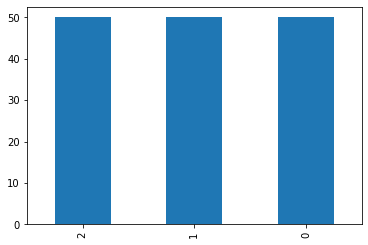

In [17]:
df['Predictions'].value_counts().plot.bar()

# overall accuracy

In [18]:
overall_accuracy = df[df['Trigger']==1].shape[0]/df.shape[0]

In [19]:
print('overall_accuracy', overall_accuracy*100)

overall_accuracy 96.0


# class wise overall accuracy

In [20]:
for i,j in labels.items():
    new_df = df[df['Species']==i]
    print(i+' class accuracy', new_df[new_df['Trigger']==1].shape[0]/new_df.shape[0])

Iris-setosa class accuracy 1.0
Iris-virginica class accuracy 0.94
Iris-versicolor class accuracy 0.94


# confusion matrix

In [21]:
pd.crosstab(df['Target'],df['Predictions'])

Predictions,0,1,2
Target,,,
0,50,0,0
1,0,47,3
2,0,3,47


# Class wise ROC Curve

In [22]:
def on_2_rest(l,ind,actual,t):
    roc_prob=[]
    pred_prob = []
    prob_list = [i[ind] for i in l]
    for i in prob_list:
        roc_prob.append(1-i)
    for i in range(0,len(actual)):
        if actual[i] == ind:
            actual[i] = 0
        else:
            actual[i] = 1
    for i in roc_prob:
        if i>t:
            pred_prob.append(1)
        else:
            pred_prob.append(0)
    return actual, roc_prob, pred_prob

def fpr_tpr(l,ind,actual,t):
    roc_actual, roc_prob, pred_prob = on_2_rest(l,ind,actual,t)
    tp=0; tn=0; fp=0; fn=0
    dummy = pd.DataFrame()
    dummy['roc_actual'] = roc_actual
    dummy['pred_prob'] = pred_prob
    for index, instn in dummy.iterrows():
        act = instn['roc_actual']
        prob = instn['pred_prob']
        if (act == 0) & (prob == 0):
            tp=tp+1
        elif (act == 1) & (prob == 1):
            tn=tn+1
        elif (act == 0) & (prob == 1):
            fp=fp+1
        else:
            fn=fn+1
    tpr = tp / (tp+fn)
    fpr = fp / (fp+tn)
    return fpr, tpr, roc_actual, roc_prob

1.0
0.9924
0.9924000000000001


Text(0.5, 1.0, 'Receiver operating characteristic example')

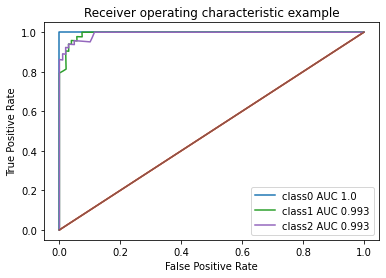

In [26]:
for i in [0,1,2]:
    threshold=[]
    fpr_l=[]
    tpr_l=[]
    threshold.append(0.0)
    fpr_l.append(1.0)
    tpr_l.append(1.0)
    for t in np.array(list(range(1,100,1)))/100:
        fpr, tpr, _, _ = fpr_tpr(pblty,i,df['Target'].values.tolist(),t)
        threshold.append(t)
        fpr_l.append(fpr)
        tpr_l.append(tpr)
    threshold.append(2.0)
    fpr_l.append(0.0)
    tpr_l.append(0.0)
    new_df = pd.DataFrame()
    new_df['threshold'] = threshold
    new_df['x'] = fpr_l
    new_df['y'] = tpr_l
    plt.plot(new_df.x,new_df.y, label='class'+str(i)+' AUC '+str(round(1-abs(np.trapz(new_df.x,new_df.y)),3)))
    plt.plot([0,1])
    plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')

# Question 2
Shuffle the data with seed value 42 and perform a 70- 30 stratified split of the data into a train and test set.
Also, plot the class-wise distribution of data in the train and test set (one for train set and one for test set).
Compare the distributions. Now, perform classification as follows:

# a)
Train a Gaussian Naive Bayes classifier and report (a) the class priors, (b) mean and variance of
each feature per class.

In [505]:
from sklearn.datasets import load_wine
data = load_wine()

In [506]:
dff = pd.DataFrame(data.data, columns=data.feature_names)
dff['target'] = pd.Series(data.target)
dff.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [507]:
cols=[]
for i in dff.columns:
    if (i!='target'):
        cols.append(i)

In [508]:
labels = list(dff['target'].value_counts().index)

In [509]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dff,test_size=0.3, random_state=42)

# plot the class-wise distribution of data in the train and test set

<AxesSubplot:>

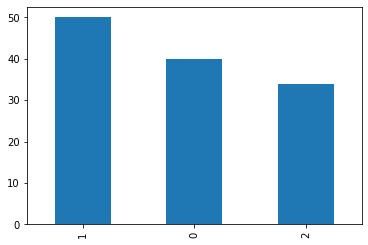

In [510]:
train['target'].value_counts().plot.bar()

<AxesSubplot:>

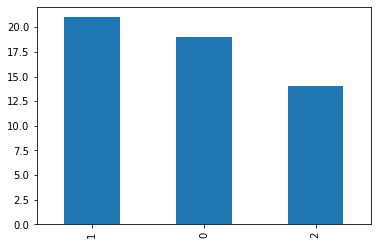

In [511]:
test['target'].value_counts().plot.bar()

In [512]:
classes = list(dff['target'].value_counts().index)
classes_encode = [1,0,2]
labels = dict(zip(classes,classes_encode))

# report on class priors, mean and variance of each feature per class.

In [513]:
NB = NaiveBayes(train, cols,'target',labels)
model = NB.fit(Report=True)

mean of class 1 for feature alcohol is 12.242800000000003
std of class 1 for feature alcohol is 0.5686110538955824
mean of class 0 for feature alcohol is 13.75025
std of class 0 for feature alcohol is 0.5099295451585847
mean of class 2 for feature alcohol is 13.097058823529412
std of class 2 for feature alcohol is 0.5443012168062423
***************************************************************************
mean of class 1 for feature malic_acid is 2.0414000000000003
std of class 1 for feature malic_acid is 1.0196398123547232
mean of class 0 for feature malic_acid is 2.0
std of class 0 for feature malic_acid is 0.6564707504175994
mean of class 2 for feature malic_acid is 3.4088235294117646
std of class 2 for feature malic_acid is 1.0191433262449352
***************************************************************************
mean of class 1 for feature ash is 2.2594
std of class 1 for feature ash is 0.31791033262830065
mean of class 0 for feature ash is 2.449
std of class 0 for feature a

In [514]:
features = test[cols].values

In [515]:
preds, pblty_w = NB.predict(model,features,3)

In [516]:
test['Predictions'] = preds

C:\Python\Python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

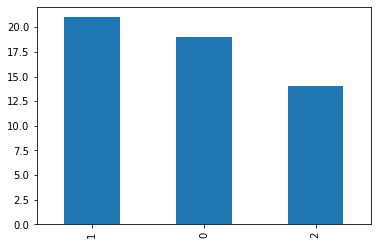

In [517]:
test['Predictions'].value_counts().plot.bar()

In [518]:
def trigger(x,y):
    if x==y:
        return 1
    else:
        return 0
    

In [519]:
test['Trigger'] = test.apply(lambda x : trigger(x['target'],x['Predictions']), axis=1)

C:\Python\Python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [520]:
test['Trigger'].value_counts()

1    54
Name: Trigger, dtype: int64

In [521]:
overall_accuracy = test[test['Trigger']==1].shape[0]/test.shape[0]

# overall accuracy

In [522]:
print('overall_accuracy', overall_accuracy*100)

overall_accuracy 100.0


# class wise overall accuracy

In [523]:
for i in labels:
    new_df = test[test['target']==i]
    print(str(i)+' class accuracy', 100*new_df[new_df['Trigger']==1].shape[0]/new_df.shape[0])

1 class accuracy 100.0
0 class accuracy 100.0
2 class accuracy 100.0


# confusion matrix

In [524]:
pd.crosstab(test['target'],test['Predictions'])

Predictions,0,1,2
target,,,
0,19,0,0
1,0,21,0
2,0,0,14


# Class wise ROC Curve

Text(0.5, 1.0, 'Receiver operating characteristic example')

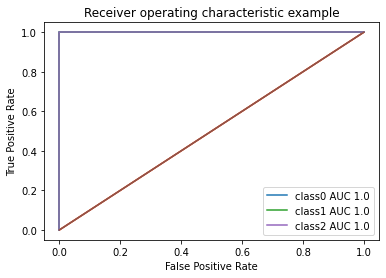

In [526]:
for i in [0,1,2]:
    threshold=[]
    fpr_l=[]
    tpr_l=[]
    threshold.append(0.0)
    fpr_l.append(1.0)
    tpr_l.append(1.0)
    for t in np.array(list(range(1,100,1)))/100:
        fpr, tpr, _, _ = fpr_tpr(pblty_w,i,test['target'].values.tolist(),t)
        threshold.append(t)
        fpr_l.append(fpr)
        tpr_l.append(tpr)
    threshold.append(2.0)
    fpr_l.append(0.0)
    tpr_l.append(0.0)
    new_df = pd.DataFrame()
    new_df['threshold'] = threshold
    new_df['x'] = fpr_l
    new_df['y'] = tpr_l
    plt.plot(new_df.x,new_df.y, label='class'+str(i)+' AUC '+str(round(1-abs(np.trapz(new_df.x,new_df.y)),2)))
    plt.plot([0,1])
    plt.legend(loc="lower right")
    from sklearn.metrics import roc_auc_score
    print(roc_auc_score(actual_a,prob_a))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')

# (b) 
Train another Gaussian Naive Bayes classifier by setting prior probability for the classes. Repeat this
experiment by setting priors in the ratios: (a) 40-40-20 and (b) 80-10-10.

# (a) 40-40-20

In [461]:
model[0] = 40
model[1] = 40
model[2] = 20

In [463]:
preds, pblty_w  = NB.predict(model,features,3)

In [464]:
test['Predictions'] = preds

C:\Python\Python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

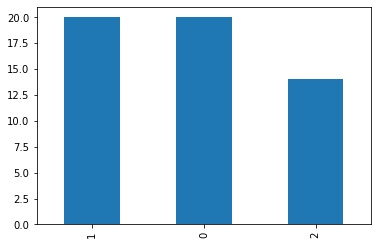

In [465]:
test['Predictions'].value_counts().plot.bar()

In [466]:
test['Trigger'] = test.apply(lambda x : trigger(x['target'],x['Predictions']), axis=1)

C:\Python\Python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# overall accuracy

In [467]:
overall_accuracy = test[test['Trigger']==1].shape[0]/test.shape[0]
print('overall_accuracy', overall_accuracy*100)

overall_accuracy 98.14814814814815


# class wise accuracy

In [468]:
for i in labels:
    new_df = test[test['target']==i]
    print(str(i)+' class accuracy', 100*new_df[new_df['Trigger']==1].shape[0]/new_df.shape[0])

1 class accuracy 95.23809523809524
0 class accuracy 100.0
2 class accuracy 100.0


# confusion matrix

In [469]:
pd.crosstab(test['target'],test['Predictions'])

Predictions,0,1,2
target,,,
0,19,0,0
1,1,20,0
2,0,0,14


# class wise ROC curve

Text(0.5, 1.0, 'Receiver operating characteristic example')

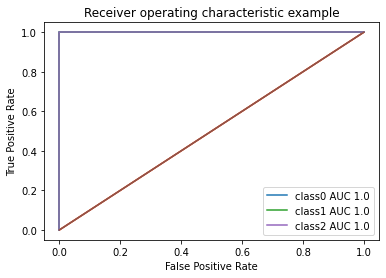

In [527]:
for i in [0,1,2]:
    threshold=[]
    fpr_l=[]
    tpr_l=[]
    threshold.append(0.0)
    fpr_l.append(1.0)
    tpr_l.append(1.0)
    for t in np.array(list(range(1,100,5)))/100:
        fpr, tpr, _, _ = fpr_tpr(pblty_w,i,test['target'].values.tolist(),t)
        threshold.append(t)
        fpr_l.append(fpr)
        tpr_l.append(tpr)
    threshold.append(2.0)
    fpr_l.append(0.0)
    tpr_l.append(0.0)
    new_df = pd.DataFrame()
    new_df['threshold'] = threshold
    new_df['x'] = fpr_l
    new_df['y'] = tpr_l
    plt.plot(new_df.x,new_df.y, label='class'+str(i)+' AUC '+str(round(1-abs(np.trapz(new_df.x,new_df.y)),2)))
    plt.plot([0,1])
    plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')

# (b) 80-10-10.

In [528]:
model[0] = 80
model[1] = 10
model[2] = 10

In [529]:
preds, pblty_w = NB.predict(model,features,3)

In [530]:
test['Predictions'] = preds
test['Trigger'] = test.apply(lambda x : trigger(x['target'],x['Predictions']), axis=1)

C:\Python\Python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:>

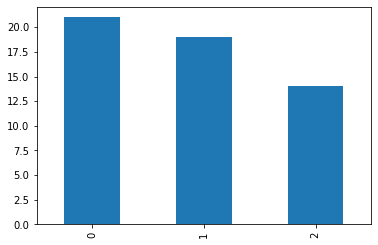

In [531]:
test['Predictions'].value_counts().plot.bar()

# overall accuracy

In [532]:
overall_accuracy = test[test['Trigger']==1].shape[0]/test.shape[0]
print('overall_accuracy', overall_accuracy*100)

overall_accuracy 96.29629629629629


# class wise accuracy

In [533]:
for i in labels:
    new_df = test[test['target']==i]
    print(str(i)+' class accuracy', 100*new_df[new_df['Trigger']==1].shape[0]/new_df.shape[0])

1 class accuracy 90.47619047619048
0 class accuracy 100.0
2 class accuracy 100.0


# confusion matrix

In [534]:
pd.crosstab(test['target'],test['Predictions'])

Predictions,0,1,2
target,,,
0,19,0,0
1,2,19,0
2,0,0,14


# class wise ROC curve

Text(0.5, 1.0, 'Receiver operating characteristic example')

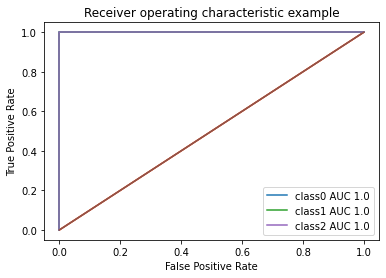

In [535]:
for i in [0,1,2]:
    threshold=[]
    fpr_l=[]
    tpr_l=[]
    threshold.append(0.0)
    fpr_l.append(1.0)
    tpr_l.append(1.0)
    for t in np.array(list(range(1,100,5)))/100:
        fpr, tpr, _, _ = fpr_tpr(pblty_w,i,test['target'].values.tolist(),t)
        threshold.append(t)
        fpr_l.append(fpr)
        tpr_l.append(tpr)
    threshold.append(2.0)
    fpr_l.append(0.0)
    tpr_l.append(0.0)
    new_df = pd.DataFrame()
    new_df['threshold'] = threshold
    new_df['x'] = fpr_l
    new_df['y'] = tpr_l
    plt.plot(new_df.x,new_df.y, label='class'+str(i)+' AUC '+str(round(1-abs(np.trapz(new_df.x,new_df.y)),2)))
    plt.plot([0,1])
    plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')

In [1]:
import pandas as pd

In [2]:
pdf = pd.DataFrame()

In [3]:
pdf['a'] = [2490,2510,2360,2410,2300,2400]

In [4]:
pdf.describe()

,a
count,6.000000
mean,2411.666667
std,78.845841
min,2300.000000
25%,2370.000000
50%,2405.000000
75%,2470.000000
max,2510.000000
